### 스마트폴 데이터 전처리 기준

#### 1. 공영주차장: 주차면적 5이상만 고려
#### 2. 충전소 리스트: 제한없음
#### 3. 공영주차장 충전소 리스트: 충전소 중에서도 공영주차장에 세워진 충전소만 고려
#### 4. 환경부크롤링데이터: 전체적인 데이터도 있지만 그중에서도 사용중인 충전소에 초점
#### 5. 타기관크롤링데이터: 전체적인 데이터도 있지만 그중에서도 급속이고, 사용중인 충전소에 초점
#### 6. 교통량: 업무지 위주의 충전소를 원하는 전기차 수요층 및 구매자 조사를 고려, 7시와 15시에 초점
#### 7. 인구데이터: 업무지 위주의 충전소를 원하는 전기차 수요층 및 구매자 조사를 고려, 9시에 초점
#### 8. 전기차 등록현황: 제한없음
#### 9. 서울 노드+링크: 제한없음

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager,rc 
import folium
import json
#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
#- 값 깨짐 방지
matplotlib.rcParams['axes.unicode_minus']=False

%matplotlib inline

#폰트 선명하게 보이도록 설정 
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

In [2]:
vs3=pd.read_csv('data/최종데이터프레임.csv')
vs3.head()

,공영주차장에 세워진 충전소(동별 개수),공영주차장(동별 개수),50이상주차장,전체 충전소(동별 개수),전기차 등록현황(동별),9시기준 누적생활인구(동별),환경부8/13충전소사용량(동별),환경부8/17충전소사용량(동별),환경부8/18충전소사용량(동별),환경부8/20충전소사용량(동별),7시교통량(동별),15시교통량(동별)
0,0,4,1,19,163,2217030,0,0,0,1,258886,233350
1,0,1,1,3,5,309644,3,1,1,2,37925,33424
2,2,20,4,61,220,2363375,0,0,0,0,210345,185044
3,0,4,82,16,90,1703136,17,13,10,6,236764,221805
4,0,0,0,1,5,49270,0,0,0,0,2695,2596


In [3]:
# 동별 개수를 가진 데이터프레임중 필요한 요소만 final에 저장
final=vs3.copy()
final=final.drop(final.columns[[0,2,6,7,8]],axis=1) #중복되는 구 컬럼 제거
final=final.rename(columns={'환경부8/20충전소사용량(동별)':'환경부충전소사용량(동별)'})
final.head()

,공영주차장(동별 개수),전체 충전소(동별 개수),전기차 등록현황(동별),9시기준 누적생활인구(동별),환경부충전소사용량(동별),7시교통량(동별),15시교통량(동별)
0,4,19,163,2217030,1,258886,233350
1,1,3,5,309644,2,37925,33424
2,20,61,220,2363375,0,210345,185044
3,4,16,90,1703136,6,236764,221805
4,0,1,5,49270,0,2695,2596


In [4]:
# 구, 동 정보를 입력할 데이터프레임 불러옴
df=pd.read_csv('data/법정동코드.csv')
df=df[['구','동']]
df=df.sort_values(by='동')
df=df.reset_index(drop=True)
df=df.applymap(lambda x:str(x).strip())
df

,구,동
0,송파구,가락동
1,구로구,가리봉동
2,금천구,가산동
3,강서구,가양동
4,종로구,가회동
...,...,...
462,용산구,후암동
463,종로구,훈정동
464,동대문구,휘경동
465,동작구,흑석동


In [5]:
#모든 특성이 같은 값을 가지게 하기위해 minmaxscaler 진행 + 동의 가나다순으로 정리했던 데이터프레임이기때문에 동정보를 그대로 넣어준다.
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler()
z_final=final.copy()
z_final[['공영주차장(동별 개수)','전체 충전소(동별 개수)','전기차 등록현황(동별)',"9시기준 누적생활인구(동별)","환경부충전소사용량(동별)",'7시교통량(동별)','15시교통량(동별)']]=\
scaler.fit_transform(z_final[['공영주차장(동별 개수)','전체 충전소(동별 개수)','전기차 등록현황(동별)',"9시기준 누적생활인구(동별)","환경부충전소사용량(동별)",'7시교통량(동별)','15시교통량(동별)']])
z_final['동']=list(df['동'])
z_final.head()

,공영주차장(동별 개수),전체 충전소(동별 개수),전기차 등록현황(동별),9시기준 누적생활인구(동별),환경부충전소사용량(동별),7시교통량(동별),15시교통량(동별),동
0,0.137931,0.275362,0.027450,0.406376,0.1,0.453137,0.451418,가락동
1,0.034483,0.043478,0.000842,0.056757,0.2,0.066381,0.064659,가리봉동
2,0.689655,0.884058,0.037050,0.433201,0.0,0.368174,0.357969,가산동
3,0.137931,0.231884,0.015157,0.312181,0.6,0.414416,0.429084,가양동
4,0.000000,0.014493,0.000842,0.009031,0.0,0.004717,0.005022,가회동


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

X = z_final[["공영주차장(동별 개수)",'전기차 등록현황(동별)','9시기준 누적생활인구(동별)','환경부충전소사용량(동별)','7시교통량(동별)','15시교통량(동별)']]
y = z_final['전체 충전소(동별 개수)']
regr = linear_model.LinearRegression()
regr.fit(X, y)
FS_coeff = regr.coef_
print('충전소 Intercept: ', regr.intercept_) #절편 
print('충전소 Coefficients: \n', FS_coeff) #기울기

충전소 Intercept:  0.0031373178913039756
충전소 Coefficients: 
 [ 0.04945569 -0.10245867  0.42264863  0.13476215 -0.29184888  0.68313562]


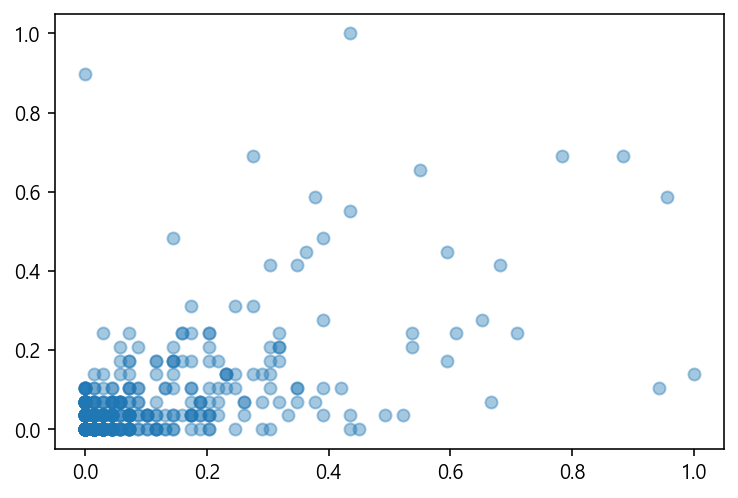

In [7]:
plt.scatter(z_final[['전체 충전소(동별 개수)']],z_final[['공영주차장(동별 개수)']],alpha=0.4)
plt.show()

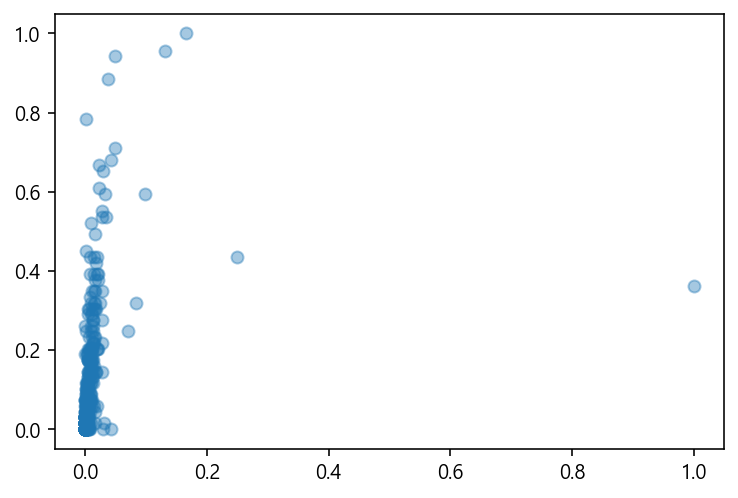

In [8]:
plt.scatter(z_final[['전기차 등록현황(동별)']],z_final[['전체 충전소(동별 개수)']],alpha=0.4)
plt.show()

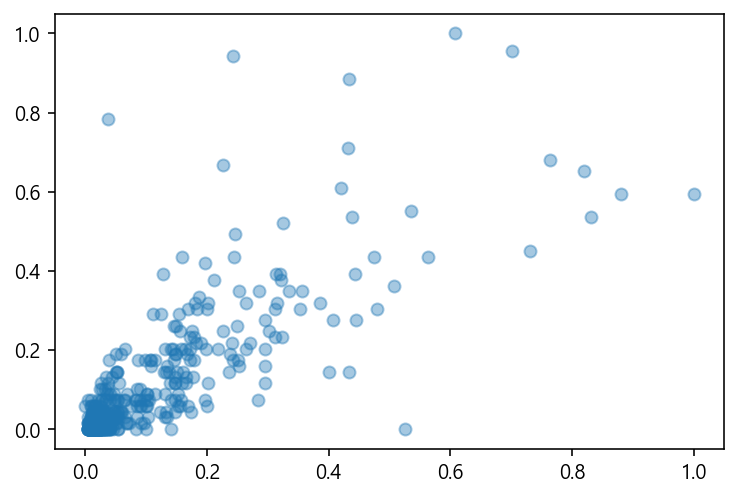

In [9]:
plt.scatter(z_final[['9시기준 누적생활인구(동별)']],z_final[['전체 충전소(동별 개수)']],alpha=0.4)
plt.show()

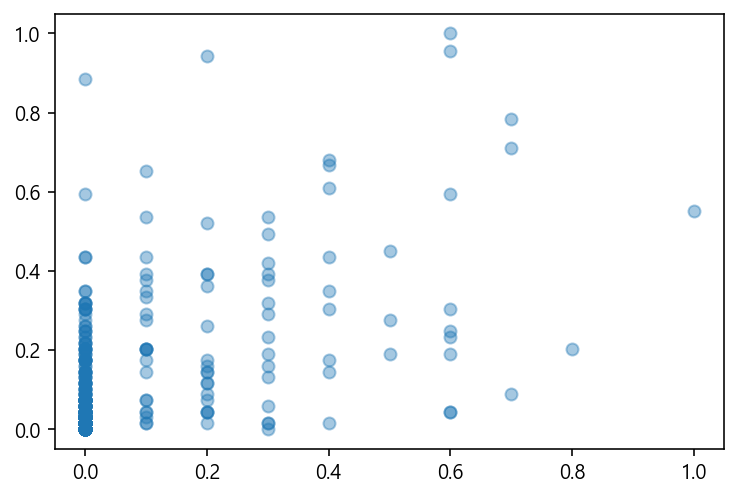

In [10]:
plt.scatter(z_final[['환경부충전소사용량(동별)']],z_final[['전체 충전소(동별 개수)']],alpha=0.4)
plt.show()

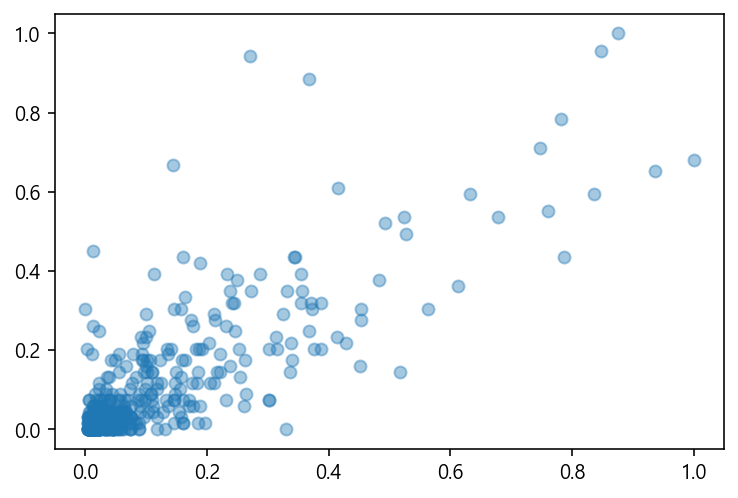

In [11]:
plt.scatter(z_final[['7시교통량(동별)']],z_final[['전체 충전소(동별 개수)']],alpha=0.4)
plt.show()

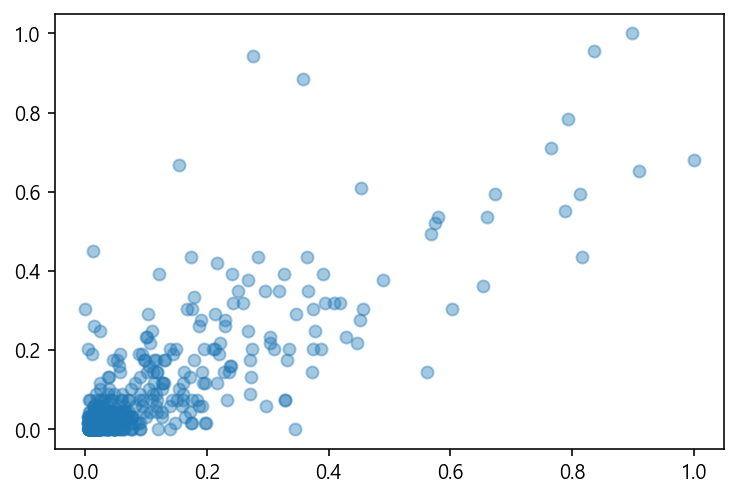

In [12]:
plt.scatter(z_final[['15시교통량(동별)']],z_final[['전체 충전소(동별 개수)']],alpha=0.4)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

df=z_final[['전체 충전소(동별 개수)',"공영주차장(동별 개수)",'전기차 등록현황(동별)','9시기준 누적생활인구(동별)','환경부충전소사용량(동별)','7시교통량(동별)','15시교통량(동별)']]

X = df[df.columns.difference(['y'])]
y = df['전체 충전소(동별 개수)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# 회귀 분석 객체 생성(선형 회귀 모델 생성)
lr = linear_model.LinearRegression()

#fit()는 기울기와 절편을 전달하기 위함.
model = lr.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
1.0


In [16]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          전체 충전소(동별 개수)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.421e+31
Date:                Sun, 10 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:39:24   Log-Likelihood:                 13092.
No. Observations:                 373   AIC:                        -2.617e+04
Df Residuals:                     365   BIC:                        -2.614e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.379e-16   8.93e-18    -15.436      0.000   -1.55e-16    -1.2e-16
15시교통량(동별)        2.22e-16   4.74e-16      0.469      0.639   -7.09e-16    1.15e-15
7시교통량(동별)        2.776e-16   4.85e-16      0.572      0.568   -6.77e-16    1.23e-15
9시기준 누적생활인구(동별)  -1.11e-16   1.16e-16     -0.956      0.340   -3.39e-16    1.17e-16
공영주차장(동별 개수)    -3.608e-16   7.96e-17     -4.536      0.000   -5.17e-16   -2.04e-16
전기차 등록현황(동별)     5.135e-16   1.46e-16      3.513      0.000    2.26e-16    8.01e-16
전체 충전소(동별 개수)       1.0000   8.34e-17    1.2e+16      0.000       1.000       1.000
환경부충전소사용량(동별)            0   6.32e-17          0      1.000   -1.24e-16    1.24e-16
==============================================================================
Omnibus:                      321.525   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13861.128
Skew:                          -3.285   Prob(JB):                         0.00
Kurtosis:                      32.133   Cond. No.                         95.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""